# Response

## Libraries and macros

In [1]:
import ROOT
import pyspark
import numpy as np
import fnmatch
from os import listdir

# ROOT.gInterpreter.AddIncludePath('../macros/')

# ROOT.gROOT.LoadMacro('../macros/tdrstyle_mod15.C')
# ROOT.gSystem.Load('../macros/./Nhelpers_C.so')
# ROOT.gSystem.Load('../macros/./tdrstyle_mod15_C.so')


ROOT.gStyle.SetPalette(ROOT.kGreyYellow) # LightTemperature

# ROOT.EnableImplicitMT()

Welcome to JupyROOT 6.27/01


### Spark

In [2]:
RDataFrame = ROOT.RDF.Experimental.Distributed.Spark.RDataFrame
RunGraphs = ROOT.RDF.Experimental.Distributed.RunGraphs

## Data

###  Read the RDataFrame

In [3]:
files = list(fnmatch.filter(listdir("../../data/20UL18JMENano_106X_upgrade2018_realistic_v16_L1v1-v1/30000"), "*.root"))

chain = ROOT.TChain("Events")

for file in files:
    chain.Add("root://eosuser.cern.ch//eos/user/n/ntoikka/data/20UL18JMENano_106X_upgrade2018_realistic_v16_L1v1-v1/30000/"+file)
    # chain.Add("../../data/20UL18JMENano_106X_upgrade2018_realistic_v16_L1v1-v1/30000/"+file)
    # print("../../data/20UL18JMENano_106X_upgrade2018_realistic_v16_L1v1-v1/30000/"+file)

print(f"Event count: {chain.GetEntries()}")

# df = ROOT.RDataFrame(chain) "Events", "root://eosuser.cern.ch//eos/user/n/ntoikka/data/20UL18JMENano_106X_upgrade2018_realistic_v16_L1v1-v1/30000/0230241E-754C-954D-B5D5-C104C1550830.root"
df = RDataFrame(chain, sparkcontext=sc, npartitions=128)

df._headnode.backend.distribute_headers("../macros/Nhelpers.hpp")
df._headnode.backend.distribute_headers("../macros/tdrstyle_mod15.hpp")

style = ROOT.setTDRStyle()

Event count: 19928000


Warning in <TClass::Init>: no dictionary for class edm::Hash<1> is available
Warning in <TClass::Init>: no dictionary for class edm::ProcessHistory is available
Warning in <TClass::Init>: no dictionary for class edm::ProcessConfiguration is available
Warning in <TClass::Init>: no dictionary for class edm::ParameterSetBlob is available
Warning in <TClass::Init>: no dictionary for class pair<edm::Hash<1>,edm::ParameterSetBlob> is available


### Veto map

In [5]:
f = ROOT.TFile("../../data/hotjets-UL18.root")
vm = f.Get("h2hot_ul18_plus_hem1516_and_hbp2m1")

read_map_code = """
TFile f("../../data/hotjets-UL18.root");
TH2D *vm = (TH2D*)f.Get("h2hot_ul18_plus_hem1516_and_hbp2m1");
auto limits = veto_map(vm, 5);

void test_lim() {
    printf("%zu", limits[0].size());
    std::endl(std::cout);
    printf("%zu", limits[1].size());
    std::endl(std::cout);
    printf("%zu", limits[2].size());
    std::endl(std::cout);
    printf("%zu", limits[3].size());
    std::endl(std::cout);
    for (int i=0; i < limits[0].size(); i++) {
        printf("i: %d  x_low: %f  x_up: %f  y_low: %f  y_up: %f ", i, limits[0][i], limits[1][i], limits[2][i], limits[3][i]);
        std::endl(std::cout);
    }
}
"""

ROOT.gInterpreter.Declare(read_map_code)


True

In [21]:
ROOT.test_lim()

5
5
5
5
i: 0  x_low: -2.964000  x_up: -1.305000  y_low: -1.570796  y_up: -0.872665 
i: 1  x_low: -1.131000  x_up: -1.044000  y_low: 0.436332  y_up: 0.523599 
i: 2  x_low: 0.000000  x_up: 1.305000  y_low: 0.436332  y_up: 0.785398 
i: 3  x_low: 1.566000  x_up: 1.740000  y_low: -1.308997  y_up: -1.221730 
i: 4  x_low: 2.500000  x_up: 2.650000  y_low: -0.523599  y_up: -0.436332 


### Filter

In [7]:
pass_filt = """
	(Flag_goodVertices) &&
	 (Flag_globalSuperTightHalo2016Filter) &&
	 (Flag_HBHENoiseFilter) &&
	 (Flag_HBHENoiseIsoFilter) &&
	 (Flag_EcalDeadCellTriggerPrimitiveFilter) &&
	 (Flag_BadPFMuonFilter) &&
	 (Flag_BadPFMuonDzFilter) &&
	 (Flag_globalTightHalo2016Filter) &&
	 (Flag_CSCTightHaloFilter) &&
	 (Flag_ecalBadCalibFilter) && 
	 (Flag_eeBadScFilter)
	""".replace("\n", "").replace("\t", "")

"Response_cut["+pass_filt+"]"

'Response_cut[(Flag_goodVertices) && (Flag_globalSuperTightHalo2016Filter) && (Flag_HBHENoiseFilter) && (Flag_HBHENoiseIsoFilter) && (Flag_EcalDeadCellTriggerPrimitiveFilter) && (Flag_BadPFMuonFilter) && (Flag_BadPFMuonDzFilter) && (Flag_globalTightHalo2016Filter) && (Flag_CSCTightHaloFilter) && (Flag_ecalBadCalibFilter) &&  (Flag_eeBadScFilter)]'

### Cuts and pairing

In [4]:
pT_cut = 15.0
eta_cut = 1.3
deltaR_cut = 0.2
veto = False
weights = False
cut_str = f'(abs(GenJet_eta) < {eta_cut}) && (GenJet_pt > {pT_cut}) && (deltaR < {deltaR_cut})'
y_str = f'Response'
if veto or weights:
    y_str += "("
    if veto:
        y_str += "vetoed"
    if weights:
        y_str += "weighted"
    y_str += ")"

df1 = df.Redefine("Jet_pt", "id_pair(Jet_pt, Jet_genJetIdx)") \
        .Redefine("Jet_eta", "id_pair(Jet_eta, Jet_genJetIdx)") \
        .Redefine("Jet_phi", "id_pair(Jet_phi, Jet_genJetIdx)") \
        .Redefine("GenJet_pt", "id_filter(GenJet_pt, Jet_genJetIdx)") \
        .Redefine("GenJet_eta", "id_filter(GenJet_eta, Jet_genJetIdx)") \
        .Redefine("GenJet_phi", "id_filter(GenJet_phi, Jet_genJetIdx)") \
        .Redefine("GenJet_partonFlavour", "id_filter(GenJet_partonFlavour, Jet_genJetIdx)") \
        .Redefine("GenJet_hadronFlavour", "id_filter(GenJet_hadronFlavour, Jet_genJetIdx)") \
        .Define("deltaR", "DeltaR(Jet_eta, GenJet_eta, Jet_phi, GenJet_phi)") \
        .Define("Response", "Jet_pt / GenJet_pt") \
        .Define("Response_cut", f"Response[{cut_str}]") \
        .Define("pFlavour_cut", f"GenJet_partonFlavour[{cut_str}]") \
        .Define("hFlavour_cut", f"GenJet_hadronFlavour[{cut_str}]") \
        .Define("pt_cut", f"GenJet_pt[{cut_str}]") \
        .Redefine("GenJet_phi", f"GenJet_phi[{cut_str}]") \
        .Redefine("GenJet_eta", f"GenJet_eta[{cut_str}]") \
        .Filter("pt_cut.size() > 0")


# df1 = df1.Redefine("GenJet_phi", f"GenJet_phi[{cut_str}]") \
#         .Redefine("GenJet_eta", f"GenJet_eta[{cut_str}]") \
#         .Filter("pt_cut.size() > 0")

if veto:
        df1 = df1.Redefine("Response_cut", "veto_map_filt(limits, GenJet_eta, GenJet_phi, Response_cut)") \
        .Redefine("pt_cut", "veto_map_filt(limits, GenJet_eta, GenJet_phi, pt_cut)")  \
        .Redefine("pFlavour_cut", "veto_map_filt(limits, GenJet_eta, GenJet_phi, pFlavour_cut)") \
        .Define("eta_new", "veto_map_filt(limits, GenJet_eta, GenJet_phi, GenJet_eta)") \
        .Define("phi_new", "veto_map_filt(limits, GenJet_eta, GenJet_phi, GenJet_phi)") \
        .Filter("pt_cut.size() > 0")

""" VETO:
        .Redefine("Response_cut", "veto_map_filt(limits, GenJet_eta, GenJet_phi, Response_cut)") \
        .Redefine("pt_cut", "veto_map_filt(limits, GenJet_eta, GenJet_phi, pt_cut)") \
        .Redefine("pFlavour_all", "veto_map_filt(limits, GenJet_eta, GenJet_phi, pFlavour_cut)") \
"""

' VETO:\n        .Redefine("Response_cut", "veto_map_filt(limits, GenJet_eta, GenJet_phi, Response_cut)")         .Redefine("pt_cut", "veto_map_filt(limits, GenJet_eta, GenJet_phi, pt_cut)")         .Redefine("pFlavour_all", "veto_map_filt(limits, GenJet_eta, GenJet_phi, pFlavour_cut)") '

In [7]:
dfN = df1.Count() #  "GenJet_pt", "Response", "Jet_pt_ap", "GenJet_pt_ap", "Jet_genJetIdx", "Response_cut", "GenJet_eta_ap", 

In [8]:
print(dfN.GetValue())

10521000


### Flavour separated responses

In [5]:
# Parton flavour based responses
df2 = df1.Define("Response_g", "flavour_match(Response_cut, abs(pFlavour_cut), 21)") \
            .Define("pt_g", "flavour_match(pt_cut, abs(pFlavour_cut), 21)") \
                \
            .Define("Response_q", "flavour_match(Response_cut, abs(pFlavour_cut), {1, 2, 3, 4, 5})") \
            .Define("pt_q", "flavour_match(pt_cut, abs(pFlavour_cut), {1, 2, 3, 4, 5})") \
                \
            .Define("Response_l", "flavour_match(Response_cut, abs(pFlavour_cut), {1, 2, 3})") \
            .Define("pt_l", "flavour_match(pt_cut, abs(pFlavour_cut), {1, 2, 3})") \
                \
            .Define("Response_b", "flavour_match(Response_cut, abs(pFlavour_cut), 5)") \
            .Define("pt_b", "flavour_match(pt_cut, abs(pFlavour_cut), 5)") \
                \
            .Define("Response_c", "flavour_match(Response_cut, abs(pFlavour_cut), 4)") \
            .Define("pt_c", "flavour_match(pt_cut, abs(pFlavour_cut), 4)") \
                \
            .Define("Response_lg", "flavour_match(Response_cut, abs(pFlavour_cut), {1, 2, 3, 21})") \
            .Define("pt_lg", "flavour_match(pt_cut, abs(pFlavour_cut), {1, 2, 3, 21})")


""" Hadron flavour:
.Define("HadronResponse_b","flavour_match(Response_cut, hFlavour_cut, 5)") \
.Define("Hpt_b", "flavour_match(pt_cut, hFlavour_cut, 5)")

.Define("HadronResponse_c","flavour_match(Response_cut, hFlavour_cut, 4)") \
.Define("Hpt_c", "flavour_match(pt_cut, hFlavour_cut, 4)")

.Define("HadronResponse_l", "flavour_match(Response_cut, hFlavour_cut, 0)") \
.Define("Hpt_l", "flavour_match(pt_cut, hFlavour_cut, 0)")
"""

' Hadron flavour:\n.Define("HadronResponse_b","flavour_match(Response_cut, hFlavour_cut, 5)") .Define("Hpt_b", "flavour_match(pt_cut, hFlavour_cut, 5)")\n\n.Define("HadronResponse_c","flavour_match(Response_cut, hFlavour_cut, 4)") .Define("Hpt_c", "flavour_match(pt_cut, hFlavour_cut, 4)")\n\n.Define("HadronResponse_l", "flavour_match(Response_cut, hFlavour_cut, 0)") .Define("Hpt_l", "flavour_match(pt_cut, hFlavour_cut, 0)")\n'

## Profiles

In [6]:
partons = ["g", "q", "l",  "c", "b", "cut"]

# Unfolded bins
bins = np.array((1, 5, 6, 8, 10, 12, 15, 18, 21, 24, 28, 32, 37, 43, 49, 56, 64, 74, 84, 97, 114, 133, \
                153, 174, 196, 220, 245, 272, 300, 330, 362, 395, 430, 468, 507, 548, 592, 638, 686, 737, \
                790, 846, 905, 967, 1032, 1101, 1172, 1248, 1327, 1410, 1497, 1588, 1684, 1784, 1890, 2000, \
                2116, 2238, 2366, 2500, 2640, 2787, 2941, 3103, 3273, 3450, 3637, 3832, 4037, 4252, 4477, 4713, \
                4961, 5220, 5492, 5777, 6076, 6389, 6717, 7000), dtype=np.double)

# Detector level bins
# bins = np.array((1, 2.5, 5, 5.5, 6, 7, 8, 9, 10, 11, 12, 13.5, 15, 16.5, 18, 19.5, 21, 22.5, 24, 26, 28, \
                # 30, 32, 34.4, 37, 39.9, 43, 46.1, 49, 52.5, 56, 60, 64, 69, 74, 79, 84, 90, 97, 105, 114, \
                # 123, 133, 143, 153, 163, 174, 185, 196, 208, 220, 232, 245, 258, 272, 286, 300, 315, 330, \
                # 346, 362, 378, 395, 412, 430, 449, 468, 487, 507, 527, 548, 570, 592, 614, 638, 662, \
                # 686, 711, 737, 763, 790, 818, 846, 875, 905, 935, 967, 999, 1032, 1066, 1101, 1136, 1172, \
                # 1209, 1248, 1287, 1327, 1368, 1410, 1453, 1497, 1542, 1588, 1636, 1684, 1733, 1784, 1836, \
                # 1890, 1944, 2000, 2057, 2116, 2176, 2238, 2301, 2366, 2432, 2500, 2569, 2640, 2712, 2787, \
                # 2863, 2941, 3021, 3103, 3187, 3273, 3360, 3450, 3542, 3637, 3733, 3832, 3933, 4037, 4143, \
                # 4252, 4364, 4477, 4594, 4713, 4836, 4961, 5089, 5220, 5355, 5492, 5633, 5777, 5925, 6076, \
                # 6231, 6389, 6552, 6717, 6886, 7000), dtype=np.double)

# Too many bins
# bins = np.geomspace(15, 7000, 250, dtype=np.double)

cnt = len(bins)-1

profiles = dict.fromkeys(partons)

hists = dict.fromkeys(partons)

if not weights:
    for flavour in partons:
        profiles[flavour] = df2.Profile1D((flavour+"Profile", flavour, cnt, bins), "pt_"+flavour, "Response_"+flavour)
        hists[flavour] = df2.Histo2D((flavour+"Hist", flavour+"HistTitle", cnt, bins, 20000, 0, 2), "pt_"+flavour, "Response_"+flavour)
else:
    for flavour in partons:
        profiles[flavour] = df2.Profile1D((flavour+"Profile", flavour, cnt, bins), "pt_"+flavour, "Response_"+flavour, "genWeight")
        hists[flavour] = df2.Histo2D((flavour+"Hist", flavour+"HistTitle", cnt, bins, 20000, 0, 2), "pt_"+flavour, "Response_"+flavour, "genWeight")


## Plots


#### eta

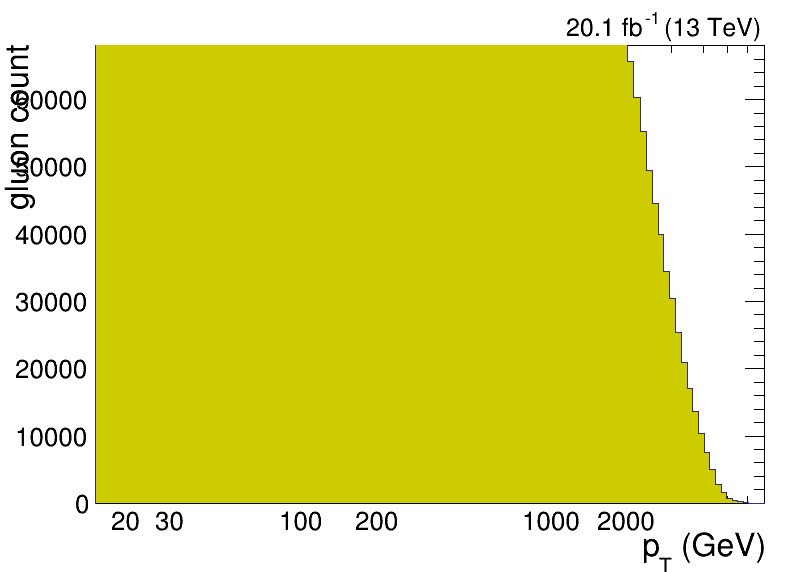

In [ ]:
%jsroot off
eta_hist = df2.Histo1D(("", "canv;p_{T};count", cnt, bins), "pt_g")
# eta_hist.GetXaxis().SetRangeUser(-6.5, 6)

# canv = ROOT.TCanvas("canv","canv;p_{T} gluon;count", 800, 600) #canv = ROOT.tdrCanvas("canvas", eta_hist.GetPtr(), iPeriod=4)

hist = ROOT.TH1D("h1", "h1 title;p_{T} (GeV);gluon count", cnt, bins)

canv = ROOT.tdrCanvas("canvas", hist, iPeriod=4)

hist.GetXaxis().SetRangeUser(15, bins[-1])
hist.GetXaxis().SetMoreLogLabels()
hist.GetYaxis().SetMoreLogLabels()
hist.GetXaxis().SetNoExponent()
hist.GetYaxis().SetRangeUser(0, 1992800)

ROOT.tdrDraw(eta_hist.GetPtr(), "PLC PMC")

canv.SetLogx()
canv.Draw()

#### rho

In [ ]:
# rho_hist = df11.Histo1D(("michale2", "mikko;fixedGridRhoFastjetAll", 100, 0, 100), "fixedGridRhoFastjetAll")
# rho_hist.GetXaxis().SetRangeUser(0, 70)

# canvPU = ROOT.tdrCanvas("canvas", rho_hist.GetPtr(), iPeriod=4)

# ROOT.tdrDraw(rho_hist.GetPtr(), "PLC PMC")

# canvPU.Draw()

#### NPVs

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


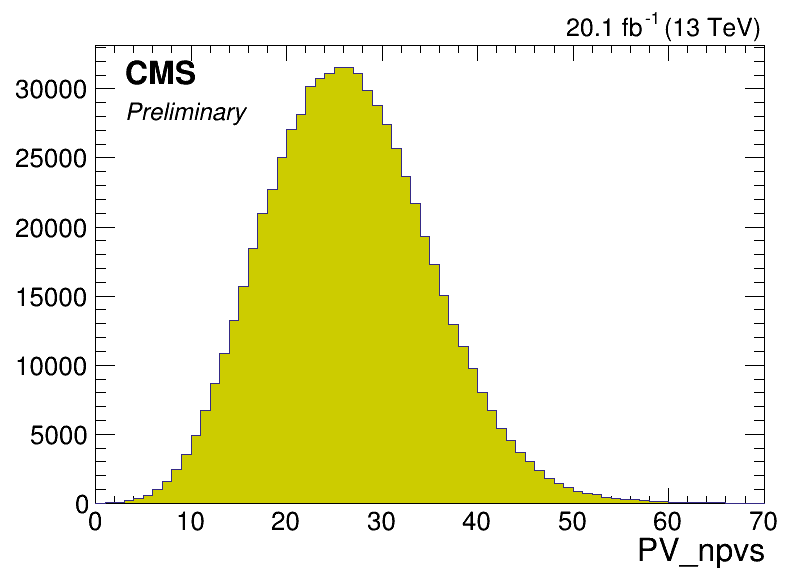

In [ ]:
# npv1_hist = df11.Histo1D(("michale2", "mikko;PV_npvs", 100, 0, 100), "PV_npvs")
# npv1_hist.GetXaxis().SetRangeUser(0, 70)

# canvPU = ROOT.tdrCanvas("canvas", npv1_hist.GetPtr(), iPeriod=4)

# ROOT.tdrDraw(npv1_hist.GetPtr(), "PLC PMC")

# canvPU.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


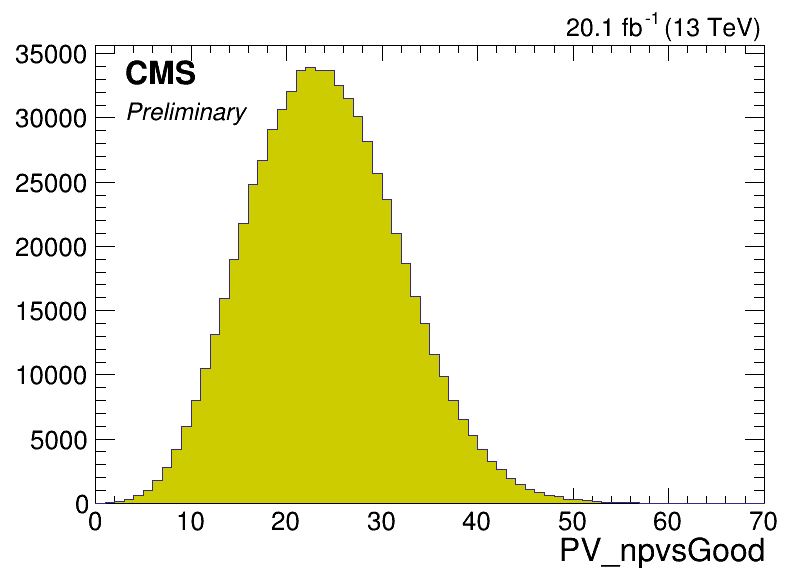

In [ ]:
npv2_hist = df11.Histo1D(("michale2", "mikko;PV_npvsGood", 100, 0, 100), "PV_npvsGood")
npv2_hist.GetXaxis().SetRangeUser(0, 70)

canvPU = ROOT.tdrCanvas("canvas", npv2_hist.GetPtr(), iPeriod=4)

ROOT.tdrDraw(npv2_hist.GetPtr(), "PLC PMC")

canvPU.Draw()

#### TruePU

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


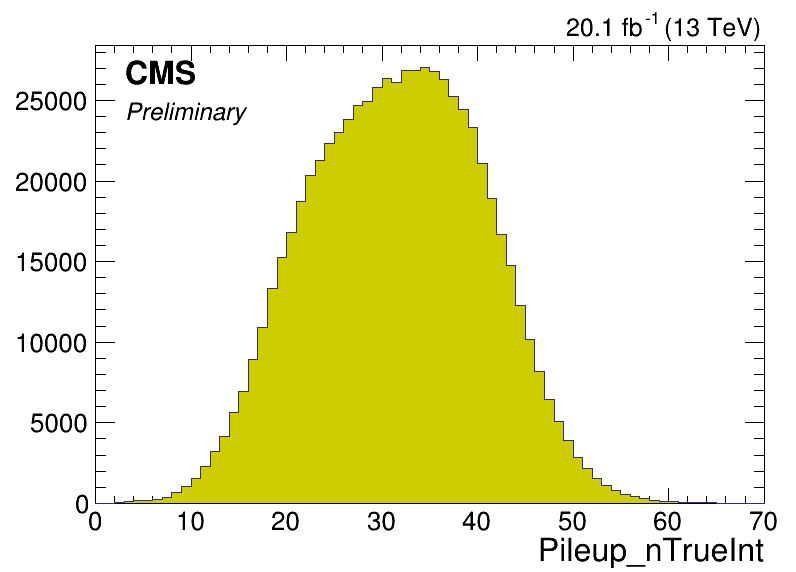

In [ ]:
# Tpu_hist = df11.Histo1D(("michale2", "mikko;Pileup_nTrueInt", 100, 0, 100), "Pileup_nTrueInt")
# Tpu_hist.GetXaxis().SetRangeUser(0, 70)

# canvPU = ROOT.tdrCanvas("canvas", Tpu_hist.GetPtr(), iPeriod=4)

# ROOT.tdrDraw(Tpu_hist.GetPtr(), "PLC PMC")

# canvPU.Draw()
# # canvPU.Close()

### rho-eta

In [7]:
hist3d = df2.Histo2D((flavour+"Hist", flavour+"HistTitle;eta;phi", 128, -5, 5, 128, -3.141, 3.141), "eta_new", "phi_new") #Histo3D(("rho_eta", "rho_eta", 32, -5, 5, 32, -3.141, 3.141, 64, 0, 3000), "eta_new", "phi_new", "pt_cut")

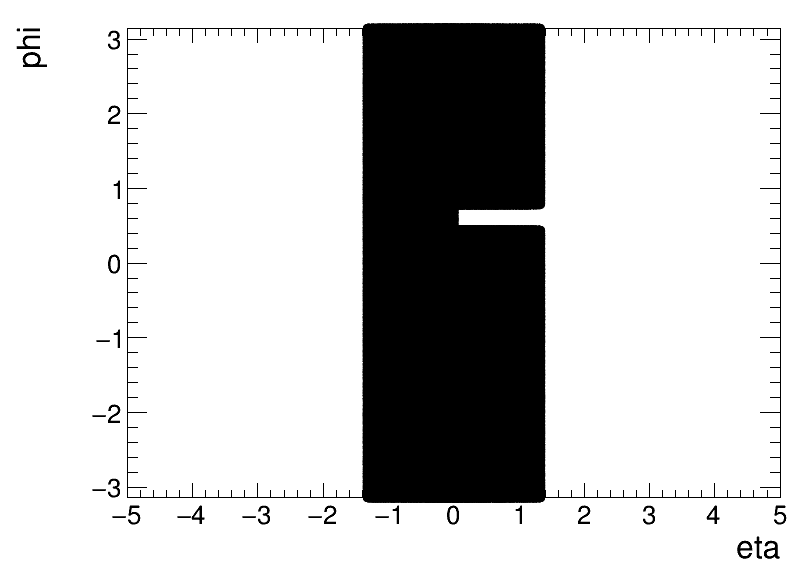

In [8]:
canv = ROOT.TCanvas("canv","canv", 800, 600)

hist3d.GetPtr().Draw()

canv.Draw("colz")

### Response, 2DHisto

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canv         


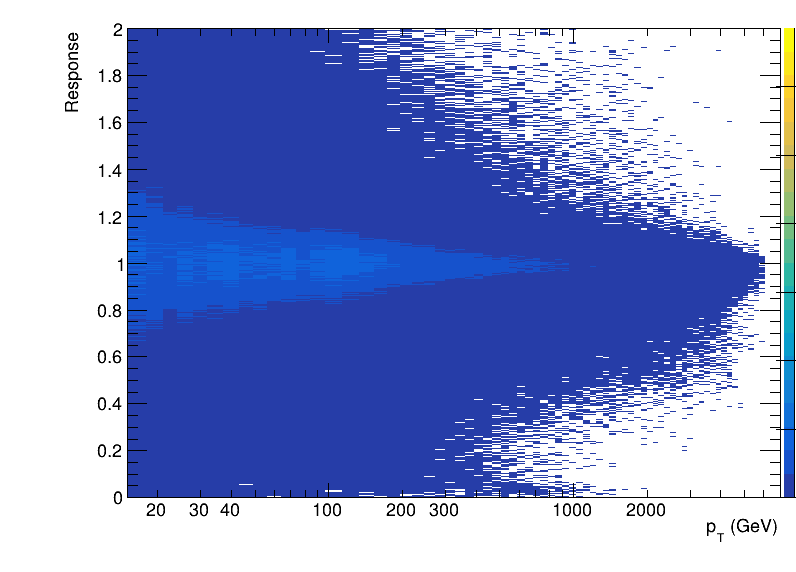

In [14]:
canv = ROOT.TCanvas("canv","canv", 800, 600)

canv.Range(15, 0.85, bins[-1], 1.2)

hists["g"].SetTitle("all;p_{T} (GeV);"+y_str)
hists["g"].GetXaxis().SetRangeUser(15, bins[-1])
hists["g"].GetYaxis().SetRangeUser(0, 2.0)
hists["g"].GetXaxis().SetMoreLogLabels()
hists["g"].GetXaxis().SetNoExponent()
hists["g"].Draw("colz")

canv.SetLogx()
canv.Draw()

In [7]:
canv = ROOT.TCanvas("canv","canv", 800, 600)
print(cnt)
dim = int(np.floor(np.sqrt(cnt)))

canv.Divide(dim, dim)
late = ROOT.TLatex()
late.SetNDC()

skip = 7

for i in range(dim*dim):
    c = canv.cd(i+1)

    hists["g"].ProjectionY(f"{i+skip}",i+skip,i+skip).Draw()

    RMS = hists["g"].ProjectionY(f"{i+skip}",i+skip,i+skip).GetRMS()
    mean = hists["g"].ProjectionY(f"{i+skip}",i+skip,i+skip).GetMean()
    if mean > 0:
        gFit = hists["g"].ProjectionY(f"{i+skip}",i+skip,i+skip).Fit("gaus", "S Q", "SAME PLC PMC", mean-RMS, mean+RMS)
        hists["g"].ProjectionY(f"{i+skip}",i+skip,i+skip).SetLineColor(2)
        mG = gFit.Parameter(1)
        sigma = gFit.Parameter(2)

        fFit = hists["g"].ProjectionY(f"{i+skip}F",i+skip,i+skip).Fit("gaus", "S Q", "SAME PLC PMC", mG-1.0*sigma, mG+1.0*sigma)
        fpar = fFit.Parameter(1)

        late.DrawLatex(.575, .7, f'{hists["g"].GetXaxis().GetBinLowEdge(i+skip)} <= pT < {hists["g"].GetXaxis().GetBinUpEdge(i+skip)}')
        late.DrawLatex(.575, .6, f'First Mean: {gFit.Parameter(1)}')
        late.DrawLatex(.575, .55, f'Final Mean: {fFit.Parameter(1)}')
        if fpar > 1.05:
            hists["g"].ProjectionY(f"{i+skip}",i+skip,i+skip).SetFillColor(7)
    # gFit = hists["g"].ProjectionY(f"{i+7}",i+7,i+7).Fit("gaus", "S Q", "SAME PLC PMC", mean-RMS, mean+RMS)


ROOT.gStyle.SetPalette(ROOT.kRainBow)
canv.Print("plots.pdf")

79


Info in <TCanvas::Print>: pdf file plots.pdf has been created                   


### Initialize graphs

In [11]:
# Initialize variables for median and Gaussian mean calculations
medians = dict.fromkeys(partons)
means = {1.0:dict.fromkeys(partons), 1.5:dict.fromkeys(partons), 2.0:dict.fromkeys(partons)}
mean_errs = {1.0:dict.fromkeys(partons), 1.5:dict.fromkeys(partons), 2.0:dict.fromkeys(partons)}

graphs = {"med":None, "Gm10":None, "Gm15":None, "Gm20":None}
vals = {"med":None, "Gm10":None, "Gm15":None, "Gm20":None}

for key in graphs.keys():
    graphs[key] = dict.fromkeys(partons)

Rbins =  ROOT.VecOps.AsRVec(bins)
binHist = ROOT.TH1D("bh", "", cnt, bins)

# Calculate medians
for flavour in partons:
    medians[flavour] = ROOT.fill_median(hists[flavour], cnt)
    graphs["med"][flavour] = ROOT.TGraph(cnt)
    for i in range(cnt):
        graphs["med"][flavour].SetPointY(i, medians[flavour][i])
        graphs["med"][flavour].SetPointX(i, binHist.GetBinCenter(i))

# Calculate means
for flavour in partons:
    for mkey in means:
        means[mkey][flavour] = ROOT.fill_gmean(hists[flavour].GetPtr(), cnt, mkey)
        mean_errs[mkey][flavour] = ROOT.fill_gmean_err(hists[flavour].GetPtr(), cnt, mkey)

    for gkey in list(graphs.keys())[1:]:
        graphs[gkey][flavour] = ROOT.TGraphErrors(cnt)

    for gkey, mkey in zip(list(graphs.keys())[1:], means.keys()):
        for i in range(cnt):
            graphs[gkey][flavour].SetPointY(i, means[mkey][flavour][i])
            graphs[gkey][flavour].SetPointX(i, binHist.GetBinCenter(i))
            graphs[gkey][flavour].SetPointError(i+1, binHist.GetBinWidth(i+1)/2, mean_errs[mkey][flavour][i])

TypeError: ROOT::VecOps::RVec<double> ::fill_median(TH2* h, int nxbins) =>
    TypeError: could not convert argument 1

Warning in <TROOT::Append>: Replacing existing TH1: bh (Potential memory leak).


In [11]:
outFileName = "2dall_pt.root"

# Open file
myFile = ROOT.TFile.Open(outFileName, "RECREATE")

ROOT.gDirectory.WriteObject(hists["g"].GetPtr(), "resp_pt_2dHist")

myFile.Close()

In [14]:
print(profiles["cut"])

### Response, all

In [13]:
%jsroot off
# Function for drawing the percentage lines-------------------------
def prc_lines():
    line = ROOT.TLine()
    line.DrawLine(15, 1, bins[-1], 1)
    line.SetLineStyle(ROOT.kDashed)
    line.DrawLine(15, 0.99, bins[-1], 0.99)
    line.DrawLine(15, 1.01, bins[-1], 1.01)
    line.DrawLine(15, 0.998, bins[-1], 0.998)
    line.DrawLine(15, 1.002, bins[-1], 1.002)

# Function for tdrStyle axes and limit setting----------------------
def tdrAxes(hist, y_low, y_up):
    hist.GetYaxis().SetRangeUser(y_low, y_up)
    hist.GetXaxis().SetRangeUser(15, bins[-1])
    hist.GetXaxis().SetMoreLogLabels()
    hist.GetXaxis().SetNoExponent()

# Plot --------------------------------------------------------------
hist = ROOT.TH1D("h1", "h1 title;p_{T} (GeV);"+y_str, cnt, bins)

tdrAxes(hist, 0.97, 1.03)

canv = ROOT.tdrCanvas("canvas", hist, iPeriod=4)

prc_lines()

ROOT.tdrDraw(profiles["cut"],"PLC PMC ")

# for keys in graphs:
#     ROOT.tdrDraw(graphs[keys]["cut"], "PLC PMC P")

# leg = ROOT.tdrLeg(0.6,0.7,0.9,0.9)
# leg.AddEntry(profiles["cut"].GetPtr(), "mean", "pl")

# for key in graphs:
#     leg.AddEntry(graphs[key]["cut"], key, "pl")

ROOT.gStyle.SetPalette(ROOT.kRainBow) #GreyYellow LightTemperature

late = ROOT.TLatex()
late.SetNDC()
late.DrawLatex(.2, .2, "|#eta| < 1.3; #DeltaR < 0.2; p_{T} > 15 GeV")

canv.SetLogx()
canv.Draw()

TypeError: none of the 2 overloaded methods succeeded. Full details:
  void ::tdrDraw(TH1* h, string opt, int marker = kFullCircle, int mcolor = kBlack, int lstyle = kSolid, int lcolor = -1, int fstyle = 1001, int fcolor = kYellow + 1) =>
    TypeError: could not convert argument 1
  void ::tdrDraw(TGraph* g, string opt, int marker = kFullCircle, int mcolor = kBlack, int lstyle = kSolid, int lcolor = -1, int fstyle = 1001, int fcolor = kYellow + 1, double msize = 1) =>
    TypeError: could not convert argument 1

Warning in <TROOT::Append>: Replacing existing TH1: h1 (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


### g hist

Warning in <TFile::Append>: Replacing existing TH1: h1 (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


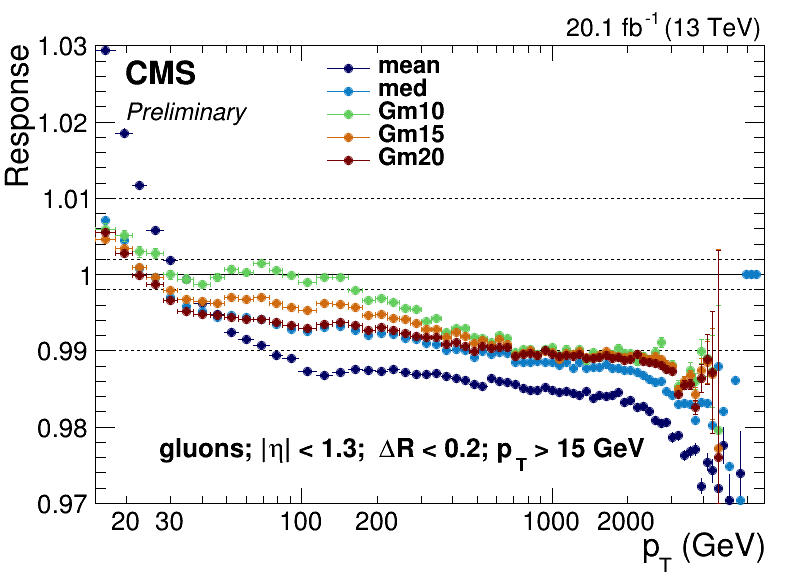

In [11]:
hist = ROOT.TH1D("h1", "h1 title;p_{T} (GeV);"+y_str, cnt, bins)

tdrAxes(hist, 0.97, 1.03)

canv = ROOT.tdrCanvas("canvas", hist, iPeriod=4)

prc_lines()

ROOT.tdrDraw(profiles["g"].GetPtr(),"PLC PMC ")
ROOT.tdrDraw(graphs["med"]["g"], "PLC PMC P")
ROOT.tdrDraw(graphs["Gm10"]["g"], "PLC PMC P")
ROOT.tdrDraw(graphs["Gm15"]["g"], "PLC PMC P")
ROOT.tdrDraw(graphs["Gm20"]["g"], "PLC PMC P")

# for key in graphs:
#     print(key)
#     ROOT.tdrDraw(graphs[keys]["g"], "PLC PMC P")

leg = ROOT.tdrLeg(0.4,0.7,0.7,0.9)
leg.AddEntry(profiles["g"].GetPtr(), "mean", "pl")

for key in graphs:
    leg.AddEntry(graphs[key]["g"], key, "pl")

ROOT.gStyle.SetPalette(ROOT.kRainBow) #GreyYellow LightTemperature

late = ROOT.TLatex()
late.SetNDC()
late.DrawLatex(.2, .2, "gluons; |#eta| < 1.3; #DeltaR < 0.2; p_{T} > 15 GeV")

canv.SetLogx()
canv.Draw()

### Response, g vs l

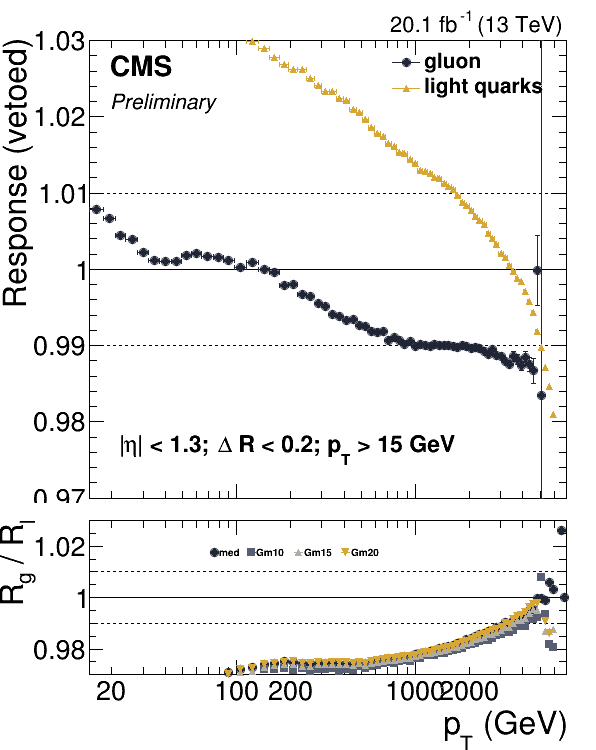

In [12]:
# Drawing hists and canvas-----------------------------------------
hist_up = ROOT.TH1D("up_h1", "up_h1 title;p_{T} (GeV);Response (vetoed)", cnt, bins)
hist_dw = ROOT.TH1D("dw_h1", "dw_h1 title;p_{T} (GeV);R_{g} / R_{l}", cnt, bins)

tdrAxes(hist_up, 0.97, 1.03)
tdrAxes(hist_dw, 0.97, 1.03)

canv = ROOT.tdrDiCanvas("g vs l", hist_up, hist_dw, iPeriod = 4)

# Response plot-----------------------------------------------------
up = canv.cd(1)

prc_lines()

ROOT.tdrDraw(graphs["Gm10"]["g"], "PLC PMC P")
ROOT.tdrDraw(graphs["Gm10"]["l"], "PLC PMC P")

graphs["Gm10"]["l"].SetMarkerStyle(ROOT.kFullTriangleUp)
graphs["Gm10"]["g"].SetMarkerStyle(ROOT.kFullCircle)

leg = ROOT.tdrLeg(0.65,0.8,0.9,0.9)
leg.AddEntry(graphs["Gm10"]["g"], "gluon", "pl")
leg.AddEntry(graphs["Gm10"]["l"], "light quarks", "pl")

late = ROOT.TLatex()
late.SetNDC()
late.DrawLatex(.2, .1, "|#eta| < 1.3; #Delta R < 0.2; p_{T} > 15 GeV")


# Ratio plot---------------------------------------------------------
low = canv.cd(2)
leg = ROOT.tdrLeg(0.35,0.7,0.65,0.9)
leg.SetNColumns(4)
prc_lines()

divisions = {"med": None, "Gm10": None, "Gm15": None, "Gm20": None}
key_f = {"Gm10": 1.0, "Gm15": 1.5, "Gm20": 2.0}

s = 20

for dkey, gkey  in zip(divisions.keys(), graphs.keys()):
    divisions[dkey] = ROOT.TH1D(dkey+"div", "", cnt, bins)#dkey+"div", "", cnt, bins)
    for i in range(cnt):
        if graphs[gkey]["l"].GetPointY(i) != 0.0:
            divisions[dkey].Fill(bins[i], graphs[gkey]["g"].GetPointY(i) / graphs[gkey]["l"].GetPointY(i))
        else:
            divisions[dkey].Fill(bins[i],0.0)


    leg.AddEntry(divisions[dkey], dkey, "pl")
    ROOT.tdrDraw(divisions[dkey], "HIST PLC PMC P")
    divisions[dkey].SetMarkerStyle(s)
    
    s=s+1

# for flav in ["g", "l"]:
#     for i in range(cnt):
#         divisions[dkey].SetBinError(i, mean_errs)

# Draw----------------------------------------------------------------
ROOT.gStyle.SetPalette(ROOT.kGreyYellow)

canv.Update()
low.SetLogx()
up.SetLogx()
canv.Draw()

#### Non-veto

In [ ]:
# Drawing hists and canvas-----------------------------------------
hist_up = ROOT.TH1D("up_h1", "up_h1 title;p_{T} (GeV);Response (vetoed)", cnt, bins)
hist_dw = ROOT.TH1D("dw_h1", "dw_h1 title;p_{T} (GeV);R_{g} / R_{l}", cnt, bins)

hist_up.GetYaxis().SetRangeUser(0.97, 1.03)
hist_up.GetXaxis().SetRangeUser(15, bins[-1])
hist_up.GetXaxis().SetMoreLogLabels()
hist_up.GetXaxis().SetNoExponent()

hist_dw.GetYaxis().SetRangeUser(0.95, 1.05)
hist_dw.GetXaxis().SetRangeUser(15, bins[-1])
hist_dw.GetXaxis().SetMoreLogLabels()
hist_dw.GetXaxis().SetNoExponent()

canv = ROOT.tdrDiCanvas("g vs l", hist_up, hist_dw, iPeriod = 4)

# Response plot-----------------------------------------------------
up = canv.cd(1)
prc_lines()

ROOT.tdrDraw(graphs["Gm10"]["g"], "PLC PMC P")
ROOT.tdrDraw(graphs["Gm10"]["l"], "PLC PMC P")

graphs["Gm10"]["l"].SetMarkerStyle(ROOT.kFullTriangleUp)
graphs["Gm10"]["g"].SetMarkerStyle(ROOT.kFullCircle)

leg = ROOT.tdrLeg(0.65,0.8,0.9,0.9)
leg.AddEntry(graphs["Gm10"]["g"], "gluon", "pl")
leg.AddEntry(graphs["Gm10"]["l"], "light quarks", "pl")

late = ROOT.TLatex()
late.SetNDC()
late.DrawLatex(.2, .1, "|#eta| < 1.3; #Delta R < 0.2; p_{T} > 15 GeV")


# Ratio plot---------------------------------------------------------
low = canv.cd(2)
leg = ROOT.tdrLeg(0.35,0.7,0.65,0.9)
leg.SetNColumns(4)
prc_lines()

divisions = {"med": None, "Gm10": None, "Gm15": None, "Gm20": None}
key_f = {"Gm10": 1.0, "Gm15": 1.5, "Gm20": 2.0}

s = 20

for dkey, gkey  in zip(divisions.keys(), graphs.keys()):
    divisions[dkey] = ROOT.TH1D(dkey+"div", "", cnt, bins)#dkey+"div", "", cnt, bins)
    for i in range(cnt):
        if graphs[gkey]["l"].GetPointY(i) != 0.0:
            divisions[dkey].Fill(bins[i], graphs[gkey]["g"].GetPointY(i) / graphs[gkey]["l"].GetPointY(i))
        else:
            divisions[dkey].Fill(bins[i],0.0)


    leg.AddEntry(divisions[dkey], dkey, "pl")
    ROOT.tdrDraw(divisions[dkey], "HIST PLC PMC P")
    divisions[dkey].SetMarkerStyle(s)
    
    s=s+1

# for flav in ["g", "l"]:
#     for i in range(cnt):
#         divisions[dkey].SetBinError(i, mean_errs)

# Draw----------------------------------------------------------------
ROOT.gStyle.SetPalette(ROOT.kGreyYellow)

canv.Update()
low.SetLogx()
up.SetLogx()
canv.Draw()

### Response, g vs q

Warning in <TFile::Append>: Replacing existing TH1: up_h1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: dw_h1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: meddiv (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: Gm10div (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: Gm15div (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: Gm20div (Potential memory leak).


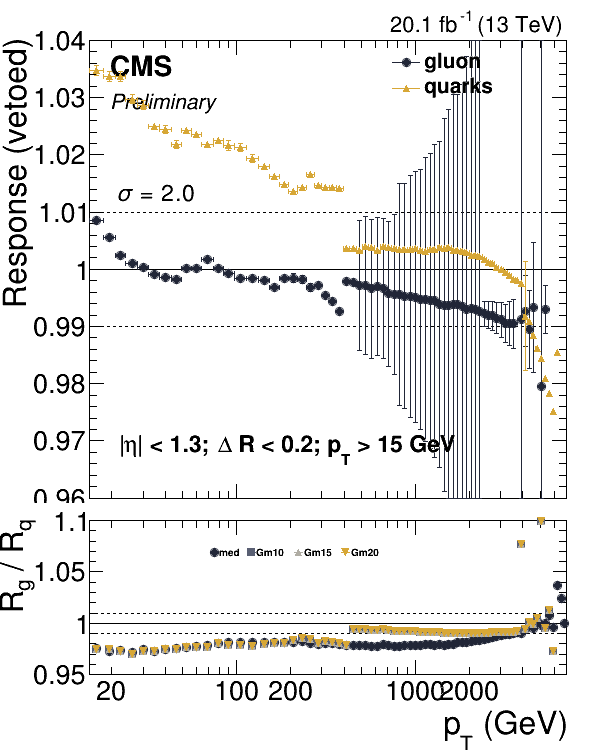

In [13]:
# Drawing hists and canvas-----------------------------------------
hist_up = ROOT.TH1D("up_h1", "up_h1 title;p_{T} (GeV);Response (vetoed)", cnt, bins)
hist_dw = ROOT.TH1D("dw_h1", "dw_h1 title;p_{T} (GeV);R_{g} / R_{q}", cnt, bins)

hist_up.GetYaxis().SetRangeUser(0.96, 1.04)
hist_up.GetXaxis().SetRangeUser(15, bins[-1])
hist_up.GetXaxis().SetMoreLogLabels()
hist_up.GetXaxis().SetNoExponent()

hist_dw.GetYaxis().SetRangeUser(0.95, 1.1)
hist_dw.GetXaxis().SetRangeUser(15, bins[-1])
hist_dw.GetXaxis().SetMoreLogLabels()
hist_dw.GetXaxis().SetNoExponent()

canv = ROOT.tdrDiCanvas("g vs q", hist_up, hist_dw, iPeriod = 4)

# Response plot-----------------------------------------------------
up = canv.cd(1)
prc_lines()

ROOT.tdrDraw(graphs["Gm20"]["g"], "PLC PMC P")
ROOT.tdrDraw(graphs["Gm20"]["q"], "PLC PMC P")

graphs["Gm20"]["q"].SetMarkerStyle(ROOT.kFullTriangleUp)
graphs["Gm20"]["g"].SetMarkerStyle(ROOT.kFullCircle)

leg = ROOT.tdrLeg(0.65,0.8,0.9,0.9)
leg.AddEntry(graphs["Gm20"]["g"], "gluon", "pl")
leg.AddEntry(graphs["Gm20"]["q"], "quarks", "pl")

late = ROOT.TLatex()
late.SetNDC()
late.DrawLatex(.2, .1, "|#eta| < 1.3; #Delta R < 0.2; p_{T} > 15 GeV")
late.DrawLatex(.2, .6, "\sigma = 2.0")


# Ratio plot---------------------------------------------------------
low = canv.cd(2)
leg = ROOT.tdrLeg(0.35,0.7,0.65,0.9)
leg.SetNColumns(4)
prc_lines()

divisions = {"med": None, "Gm10": None, "Gm15": None, "Gm20": None}

s = 20

for dkey, gkey  in zip(divisions.keys(), graphs.keys()):
    divisions[dkey] = ROOT.TH1D(dkey+"div", "", cnt, bins)#dkey+"div", "", cnt, bins)
    for i in range(cnt):
        if graphs[gkey]["q"].GetPointY(i) != 0.0:
            divisions[dkey].Fill(bins[i], graphs[gkey]["g"].GetPointY(i) / graphs[gkey]["q"].GetPointY(i))
        else:
            divisions[dkey].Fill(bins[i],0.0)

    leg.AddEntry(divisions[dkey], dkey, "pl")
    ROOT.tdrDraw(divisions[dkey], "HIST PLC PMC P")
    divisions[dkey].SetMarkerStyle(s)
    
    s=s+1

# Draw----------------------------------------------------------------
ROOT.gStyle.SetPalette(ROOT.kGreyYellow)
canv.Update()
low.SetLogx()
up.SetLogx()
canv.Draw()

### Response, g vs b

Warning in <TFile::Append>: Replacing existing TH1: up_h1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: dw_h1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: meddiv (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: Gm10div (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: Gm15div (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: Gm20div (Potential memory leak).


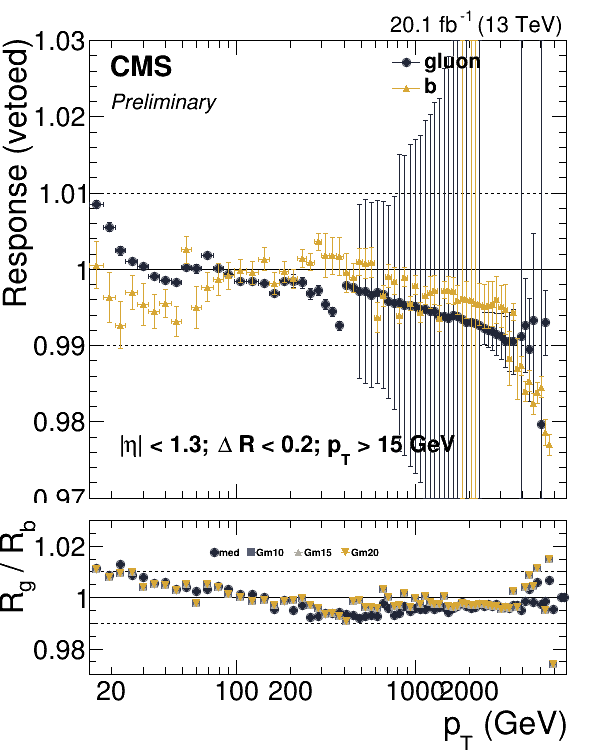

In [14]:
# Drawing hists and canvas-----------------------------------------
hist_up = ROOT.TH1D("up_h1", "up_h1 title;p_{T} (GeV);Response (vetoed)", cnt, bins)
hist_dw = ROOT.TH1D("dw_h1", "dw_h1 title;p_{T} (GeV);R_{g} / R_{b}", cnt, bins)

hist_up.GetYaxis().SetRangeUser(0.97, 1.03)
hist_up.GetXaxis().SetRangeUser(15, bins[-1])
hist_up.GetXaxis().SetMoreLogLabels()
hist_up.GetXaxis().SetNoExponent()

hist_dw.GetYaxis().SetRangeUser(0.97, 1.03)
hist_dw.GetXaxis().SetRangeUser(15, bins[-1])
hist_dw.GetXaxis().SetMoreLogLabels()
hist_dw.GetXaxis().SetNoExponent()

canv = ROOT.tdrDiCanvas("g vs b", hist_up, hist_dw, iPeriod = 4)

# Response plot-----------------------------------------------------
up = canv.cd(1)
prc_lines()

ROOT.tdrDraw(graphs["Gm20"]["g"], "PLC PMC P")
ROOT.tdrDraw(graphs["Gm20"]["b"], "PLC PMC P")

graphs["Gm20"]["b"].SetMarkerStyle(ROOT.kFullTriangleUp)
graphs["Gm20"]["g"].SetMarkerStyle(ROOT.kFullCircle)

leg = ROOT.tdrLeg(0.65,0.8,0.9,0.9)
leg.AddEntry(graphs["Gm20"]["g"], "gluon", "pl")
leg.AddEntry(graphs["Gm20"]["b"], "b", "pl")

late = ROOT.TLatex()
late.SetNDC()
late.DrawLatex(.2, .1, "|#eta| < 1.3; #Delta R < 0.2; p_{T} > 15 GeV")


# Ratio plot---------------------------------------------------------
low = canv.cd(2)
leg = ROOT.tdrLeg(0.35,0.7,0.65,0.9)
leg.SetNColumns(4)
prc_lines()

divisions = {"med": None, "Gm10": None, "Gm15": None, "Gm20": None}

s = 20

for dkey, gkey  in zip(divisions.keys(), graphs.keys()):
    divisions[dkey] = ROOT.TH1D(dkey+"div", "", cnt, bins)#dkey+"div", "", cnt, bins)
    for i in range(cnt):
        if graphs[gkey]["b"].GetPointY(i) != 0.0:
            divisions[dkey].Fill(bins[i], graphs[gkey]["g"].GetPointY(i) / graphs[gkey]["b"].GetPointY(i))
        else:
            divisions[dkey].Fill(bins[i],0.0)

    leg.AddEntry(divisions[dkey], dkey, "pl")
    ROOT.tdrDraw(divisions[dkey], "HIST PLC PMC P")
    divisions[dkey].SetMarkerStyle(s)
    
    s=s+1

# Draw----------------------------------------------------------------
ROOT.gStyle.SetPalette(ROOT.kGreyYellow)
canv.Update()
low.SetLogx()
up.SetLogx()
canv.Draw()

### Response, g vs c

Warning in <TFile::Append>: Replacing existing TH1: up_h1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: dw_h1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: meddiv (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: Gm10div (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: Gm15div (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: Gm20div (Potential memory leak).


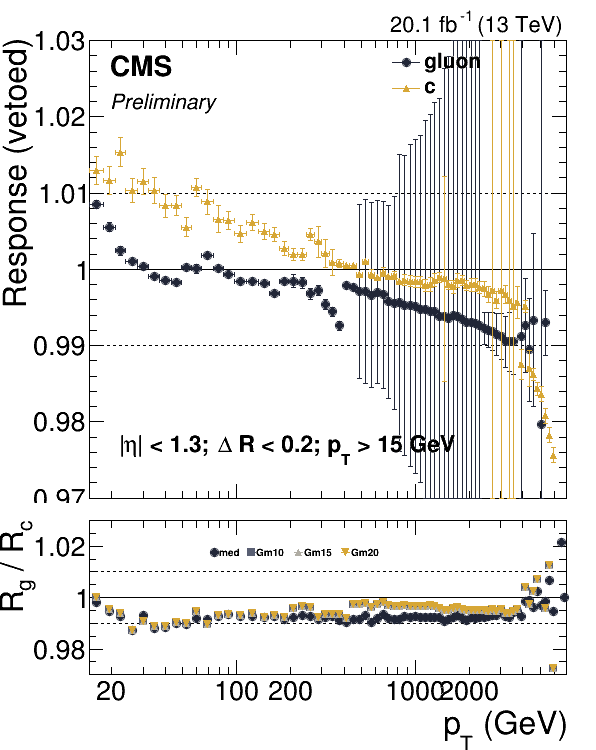

In [15]:
# Drawing hists and canvas-----------------------------------------
hist_up = ROOT.TH1D("up_h1", "up_h1 title;p_{T} (GeV);Response (vetoed)", cnt, bins)
hist_dw = ROOT.TH1D("dw_h1", "dw_h1 title;p_{T} (GeV);R_{g} / R_{c}", cnt, bins)

hist_up.GetYaxis().SetRangeUser(0.97, 1.03)
hist_up.GetXaxis().SetRangeUser(15, bins[-1])
hist_up.GetXaxis().SetMoreLogLabels()
hist_up.GetXaxis().SetNoExponent()

hist_dw.GetYaxis().SetRangeUser(0.97, 1.03)
hist_dw.GetXaxis().SetRangeUser(15, bins[-1])
hist_dw.GetXaxis().SetMoreLogLabels()
hist_dw.GetXaxis().SetNoExponent()

canv = ROOT.tdrDiCanvas("g vs c", hist_up, hist_dw, iPeriod = 4)

# Response plot-----------------------------------------------------
up = canv.cd(1)
prc_lines()

ROOT.tdrDraw(graphs["Gm20"]["g"], "PLC PMC P")
ROOT.tdrDraw(graphs["Gm20"]["c"], "PLC PMC P")

graphs["Gm20"]["c"].SetMarkerStyle(ROOT.kFullTriangleUp)
graphs["Gm20"]["g"].SetMarkerStyle(ROOT.kFullCircle)

leg = ROOT.tdrLeg(0.65,0.8,0.9,0.9)
leg.AddEntry(graphs["Gm20"]["g"], "gluon", "pl")
leg.AddEntry(graphs["Gm20"]["c"], "c", "pl")

late = ROOT.TLatex()
late.SetNDC()
late.DrawLatex(.2, .1, "|#eta| < 1.3; #Delta R < 0.2; p_{T} > 15 GeV")


# Ratio plot---------------------------------------------------------
low = canv.cd(2)
leg = ROOT.tdrLeg(0.35,0.7,0.65,0.9)
leg.SetNColumns(4)
prc_lines()

divisions = {"med": None, "Gm10": None, "Gm15": None, "Gm20": None}

s = 20

for dkey, gkey  in zip(divisions.keys(), graphs.keys()):
    divisions[dkey] = ROOT.TH1D(dkey+"div", "", cnt, bins)#dkey+"div", "", cnt, bins)
    for i in range(cnt):
        if graphs[gkey]["c"].GetPointY(i) != 0.0:
            divisions[dkey].Fill(bins[i], graphs[gkey]["g"].GetPointY(i) / graphs[gkey]["c"].GetPointY(i))
        else:
            divisions[dkey].Fill(bins[i],0.0)

    leg.AddEntry(divisions[dkey], dkey, "pl")
    ROOT.tdrDraw(divisions[dkey], "HIST PLC PMC P")
    divisions[dkey].SetMarkerStyle(s)
    
    s=s+1

# Draw----------------------------------------------------------------
ROOT.gStyle.SetPalette(ROOT.kGreyYellow)
canv.Update()
low.SetLogx()
up.SetLogx()
canv.Draw()

In [ ]:

# ROOT.gStyle.SetPalette(0)
# outFileName = "wProfs.root"
# # Open file
# myFile = ROOT.TFile.Open(outFileName, "RECREATE")


# ROOT.gDirectory.WriteObject(pg.GetPtr(), "gluon_resp_pt_profile")
# ROOT.gDirectory.WriteObject(pq, "quark_resp_pt_profile")
# ROOT.gDirectory.WriteObject(pl, "light_resp_pt_profile")
# ROOT.gDirectory.WriteObject(pb.GetPtr(), "bottom_resp_pt_profile")
# ROOT.gDirectory.WriteObject(pc.GetPtr(), "charm_resp_pt_profile")
# ROOT.gDirectory.WriteObject(plg.GetPtr(), "lightAndGluon_resp_pt_profile")
# ROOT.gDirectory.WriteObject(pall.GetPtr(), "allP_resp_pt_profile")

# myFile.Close()

### Parton vs Hadron flavour

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


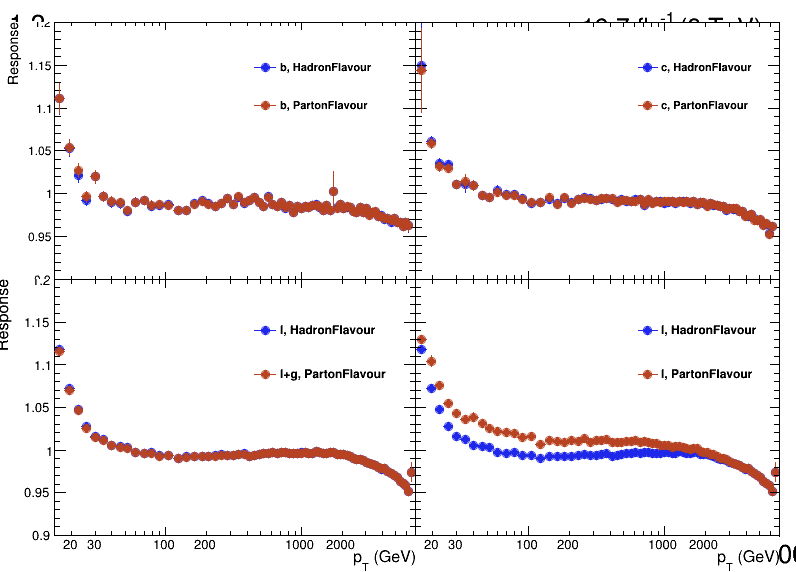

In [12]:
empt_hist = ROOT.TH1F("b", "b", cnt, bins)
canv = ROOT.tdrCanvas("canvas", pb_H.GetPtr())
ROOT.gStyle.SetPalette(ROOT.kLightTemperature)

canv.Range(15, 0.9, bins[-1], 1.2)

canv.Divide(2,2,0,0)

#b
#_____________________________________________________________________________________
p1= canv.cd(1)
pb_H.SetTitle("b, Hadron;p_{T} (GeV);Response")
pb_H.GetXaxis().SetRangeUser(15, bins[-1])
pb_H.GetYaxis().SetRangeUser(0.9, 1.20)
pb_H.GetXaxis().SetMoreLogLabels()
pb_H.GetXaxis().SetNoExponent()
# ROOT.tdrDraw(pg_fill.GetPtr(), "PLC PMC")

ROOT.tdrDraw(pb_H.GetPtr(),"PLC PMC ")
ROOT.tdrDraw(pb.GetPtr(),"PLC PMC ")


leg = ROOT.tdrLeg(0.6,0.6,0.9,0.9)
leg.AddEntry(pb_H.GetPtr(), "b, HadronFlavour", "pl")
leg.AddEntry(pb.GetPtr(), "b, PartonFlavour", "pl")
leg.SetFillStyle(0)

p1.SetLogx()

lumi = ROOT.CMS_lumi(p1, 2, 11)

# c
#_____________________________________________________________________________________
p2 = canv.cd(2)

pc_H.SetTitle("b, Hadron;p_{T} (GeV);Response")
pc_H.GetXaxis().SetRangeUser(15, bins[-1])
pc_H.GetYaxis().SetRangeUser(0.9, 1.20)
pc_H.GetXaxis().SetMoreLogLabels()
pc_H.GetXaxis().SetNoExponent()
# ROOT.tdrDraw(pg_fill.GetPtr(), "PLC PMC")

ROOT.tdrDraw(pc_H.GetPtr(),"PLC PMC ")
ROOT.tdrDraw(pc.GetPtr(),"PLC PMC ")


leg = ROOT.tdrLeg(0.6,0.6,0.9,0.9)
leg.AddEntry(pc_H.GetPtr(), "c, HadronFlavour", "pl")
leg.AddEntry(pc.GetPtr(), "c, PartonFlavour", "pl")


p2.SetLogx()

# l + g
#_____________________________________________________________________________________
p3 = canv.cd(3)

pl_H.SetTitle("l, Hadron;p_{T} (GeV);Response")
pl_H.GetXaxis().SetRangeUser(15, bins[-1])
pl_H.GetYaxis().SetRangeUser(0.9, 1.20)
pl_H.GetXaxis().SetMoreLogLabels()
pl_H.GetXaxis().SetNoExponent()
# ROOT.tdrDraw(pg_fill.GetPtr(), "PLC PMC")

ROOT.tdrDraw(pl_H.GetPtr(),"PLC PMC ")
ROOT.tdrDraw(plg.GetPtr(),"PLC PMC ")


leg = ROOT.tdrLeg(0.6,0.6,0.9,0.9)
leg.AddEntry(pl_H.GetPtr(), "l, HadronFlavour", "pl")
leg.AddEntry(plg.GetPtr(), "l+g, PartonFlavour", "pl")


p3.SetLogx()


# l - g
#_____________________________________________________________________________________
p4 = canv.cd(4)

pl_H.SetTitle("l, Hadron;p_{T} (GeV);Response")
pl_H.GetXaxis().SetRangeUser(15, bins[-1])
pl_H.GetYaxis().SetRangeUser(0.9, 1.20)
pl_H.GetXaxis().SetMoreLogLabels()
pl_H.GetXaxis().SetNoExponent()

ROOT.tdrDraw(pl_H.GetPtr(),"PLC PMC ")
ROOT.tdrDraw(pl.GetPtr(),"PLC PMC ")


leg = ROOT.tdrLeg(0.6,0.6,0.9,0.9)
leg.AddEntry(pl_H.GetPtr(), "l, HadronFlavour", "pl")
leg.AddEntry(pl.GetPtr(), "l, PartonFlavour", "pl")


p4.SetLogx()

ROOT.fixOverlay()
canv.Modified()
canv.Update()
canv.Draw()